In [152]:
############################################################
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import sodshock

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.labelpad'] = 8.0
plt.rcParams['figure.constrained_layout.h_pad'] = 0
plt.rcParams['text.usetex'] = True
plt.rc('text', usetex=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tick_params(axis='both', which='minor', labelsize=18)
import matplotlib.ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

plt.close()

plt.rc('font',family='Times New Roman')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
config = {
    "font.size": 15,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}

In [153]:
############################################################
class advection_base:
    n_var = 2;
    i_rho = 0;
    i_mom = 1;
    # 指标来区分谁是动量密度，谁是质量密度
    t     = 0;
    cfl   = 0.5;
    # i_vel = i_mom;

    def __init__( self, n, xmin, xmax, n_gh = 2 ):
        # n:选取体元数量
        # n_gh: 左右两侧ghost节点的数量
        self.u  = zeros( ( n,            self.n_var ) );
        self.f  = zeros( ( n + 1,        self.n_var ) );
        self.w  = zeros( ( n + 2 * n_gh, self.n_var ) );
        self.dx = ( xmax - xmin ) / n;
        self.xf = linspace( xmin, xmax, n + 1 );
        self.xc = ( self.xf[ 1 : ] + self.xf[ : -1 ] ) / 2;
        # 一半负数一半正数，来通过正负标定中间间断点位置，同时作为我们的横坐标
        self.n    =    n;
        self.n_gh = n_gh;
        return;
    #
    # Convention: u for conservative variables,[密度，动量密度]
    # w for primative variables [\rho,v]

    def flux_single( self, wl, wr ):
        # 目前是简单上风格式
        # Warning: Physically inconsistent, just 4 demo!
        pl = wl[ self.i_rho ] * wl[ self.i_mom ]**2;
        pr = wr[ self.i_rho ] * wr[ self.i_mom ]**2;
        # 计算压强，通过压强来判断上风侧，但是不对，需要修改。
        w  = wl if pl > pr else wr;
        # Choose the up-wind side
        v  = w [ self.i_mom ];
        # if v > 2:
        #     print( wl, wr, v );
        # w = [\rho,v]
        f  = array( w ) * v;
        return f;
    #

    def reconstruct( self ):
        # 格点边界值重建，为了求Flux，我们需要给出例如式(11)类似的左右密度矢量
        # 本函数就是最简单的Donor-cell格式，代价是差着\Delta/2的误差，因此偏差严重
        # 错开w列表，获得每一个代求流量的左侧元与右侧元，因为ghost格点的出现我们不能简单错开
        # 取n_gh = 2, self.wl = [1,:-2]，意思是包含了左侧第一个ghost节点，右侧是干净的
        # 取n_gh = 2, self.wl = [2:-1]，意思是左侧是干净的，右侧包含着一个ghost节点
        self.wl = self.w[ self.n_gh - 1 : - self.n_gh ];
        self.wr = self.w[ self.n_gh : - self.n_gh + 1 ];
        return;
    #

    def cons2prim( self ):
        # 通过守恒量来获得更便于利用的物理量，诸如密度和速度。
        self.dt = 1e32
        for i in range( len( self.u ) ):
            rho = self.u[ i, self.i_rho ];
            vel = self.vel;
            # vel = self.u[i,self.i_mom] / self.u[i,self.i_rho]
            # 这种求法是错误的，数值上不能这么干，所以
            # Warning: For Passive Advection Test Only
            self.w[ i + self.n_gh, self.i_rho ] = rho;
            self.w[ i + self.n_gh, self.i_mom ] = vel;
            dt = self.dx / vel * self.cfl;
            self.dt = minimum( self.dt, dt ) ;            
        #
        self.set_boundaries(  );
        return;
    #

    def set_boundaries( self ):
        # 外流边界条件
        for i in range( self.n_gh ):
            self.w     [ i ] = self.w     [ self.n_gh ];
        for i in range( self.n_gh ):
            self.w[ -1 - i ] = self.w[ -1 - self.n_gh ];
        return;
    #

    def flux_all( self ):
        for i in range( len( self.f ) ):
            self.f[ i ] = self.flux_single\
                 ( self.wl[ i ], self.wr[ i ] );
        return;
    #

    def integrate( self ):
        # 时间积分：RK2

        u0 = copy(self.u);
        self.cons2prim  (  );
        self.reconstruct(  );
        self.flux_all   (  );
        f0 = 1 / self.dx * ( self.f[ : -1 ] - self.f[ 1 : ] );

        u1t = u0 + self.dt * f0;
        self.u = u1t;
        self.cons2prim  (  );
        self.reconstruct(  );
        self.flux_all   (  );
        f1 = 1 / self.dx * ( self.f[ : -1 ] - self.f[ 1 : ] );

        self.u = u0 + self.dt * (f0 + f1) / 2;
        self.t += self.dt;
        return;
    #
#

In [154]:
class hydro_base( advection_base ):
    n_var = 3;
    n_dim = 1;
    
    i_rho = 0;
    i_ene = 1;
    i_mom = 2;
    gam   = 5 / 3;

    def htot( self, w ):
        v = w[ self.i_mom : self.i_mom + self.n_dim ];
        return sum( v**2 ) / 2 \
            + w[ self.i_ene ] / w[ self.i_rho ]\
            * self.gam / ( self.gam - 1 );
    #

    def flux_basic( self, w ):
        f   = zeros( len( w ) );
        rho = w[ self.i_rho ] ;
        p   = w[ self.i_ene ] ;
        v   = w[ self.i_mom : self.i_mom + self.n_dim ];
        f[ self.i_rho ]  = rho * v[ 0 ];
        f[ self.i_mom :  self.i_mom + self.n_dim ] \
            = v[ 0 ] * v * rho;
        f[ self.i_mom ] += p;
        f[ self.i_ene ]  = v[ 0 ] * rho * self.htot( w );
        return f;
    #

    def roe_ave( self, wl, wr, rhol, rhor ):
        wgt_l, wgt_r = sqrt( rhol ), sqrt( rhor );
        return ( wgt_l * wl + wgt_r * wr ) \
             / ( wgt_l + wgt_r );
    #

    def hllc( self, wl, wr ):
        rhol, pl, vl = wl[ self.i_rho ], wl[ self.i_ene ],\
                       wl[ self.i_mom ];
        rhor, pr, vr = wr[ self.i_rho ], wr[ self.i_ene ],\
                       wr[ self.i_mom ];
        hroe  = self.roe_ave\
            ( self.htot( wl ), self.htot( wr ), rhol, rhor );
        # roe氏平均下比焓
        vroe  = self.roe_ave( vl, vr, rhol, rhor );
        c2roe = ( hroe - vroe**2 / 2 ) * ( self.gam - 1 );
        croe  = sqrt( maximum( c2roe, 0 ) );

        csl   = sqrt( self.gam * pl / rhol );
        csr   = sqrt( self.gam * pr / rhor );
        sl    = minimum( vroe - croe, vl - csl );
        sr    = maximum( vroe + croe, vr + csr );
        # 式40

        ss    = ( pr - pl + rhol * vl * ( sl - vl ) \
                          - rhor * vr * ( sr - vr ) )\
              / ( rhol * ( sl - vl ) - rhor * ( sr - vr ) );
        # 式37
        ps    = pl + rhol * ( sl - vl  ) * ( ss - vl );
        # 式36
        rhols  = rhol * ( vl - sl ) / ( ss - sl );
        rhors  = rhor * ( vr - sr ) / ( ss - sr );
        # 式36上方第一式

        if   sl > 0:
            w = wl;
        elif ss > 0:
            w = array( [ rhols, ps, ss ] );
        elif sr > 0:
            w = array( [ rhors, ps, ss ] );
        else:
            w = wr;
        # 图9 判断这个点所处于的扰动状态
        #
        return self.flux_basic( w );
    #
    def flux_single( self, wl, wr ):
        return self. hllc( wl, wr );
    #

    def cons2prim( self ):
        self.dt = 1e32
        for i in range( len( self.u ) ):
            u   = self.u[ i ];
            rho = u[ self.i_rho ];
            ene = u[ self.i_ene ];
            mom = u[ self.i_mom : self.i_mom + self.n_dim ];
            vel = mom / rho;
            ek  = sum( mom**2 ) / ( 2 * rho );
            pre = ( ene - ek ) * ( self.gam -1 );
            # 压强
            w   = copy( u );
            w[ self.i_ene ] = pre;
            w[ self.i_mom : self.i_mom + self.n_dim ] = vel;
            self.w[ i + self.n_gh ] = w;

            cs   = sqrt( self.gam * pre / rho );
            vmax = max ( abs( vel ) + cs );
            dt   = self.dx / vmax * self.cfl;
            self.dt = minimum( dt, self.dt );
        #
        self.set_boundaries(  );
        return;
    #
    def minmod( self, a, b ):
        flag_a = abs( a ) < abs( b );
        flag_0 = (  a * b < 0 );
        res = copy( b );
        res[ flag_a ] = a[ flag_a ];
        res[ flag_0 ] = 0;
        return res;
    #
    def reconstruct( self ):

        # PLM限制器的reconstruct方法，参照公式(11)
        dwl = self.w[ self.n_gh - 1 : - self.n_gh ] - self.w[ self.n_gh -2 : - self.n_gh - 1 ];
        dwc = self.w[ self.n_gh : - self.n_gh + 1] - self.w[ self.n_gh - 1 : - self.n_gh ];
        if self.n_gh == 2: 
            dwr = self.w[ self.n_gh + 1:] - self.w[ self.n_gh  : - self.n_gh + 1 ];
        else:
            dwr = self.w[ self.n_gh + 1: - self.n_gh + 2] - self.w[ self.n_gh  : - self.n_gh + 1 ];

        dwl = self.minmod( dwl, dwc );
        dwr = self.minmod( dwr, dwc );

        self.wl = self.w[ self.n_gh - 1 : - self.n_gh ] + dwl / 2;
        self.wr = self.w[ self.n_gh : - self.n_gh + 1 ] - dwr / 2;
        
        return;
    

    def init_cond( self, wl, wr, x_mid = 0 ):
        wl, wr = array( wl ), array( wr );
        for i in range( len( self.u ) ):
            xc = self.xc[ i ];
            w  = wl if xc < x_mid else wr;
            u  = copy( w );
            rho = w[ self.i_rho ];
            pre = w[ self.i_ene ];
            vel = w[ self.i_mom : self.i_mom + self.n_dim];
            u[ self.i_mom : self.i_mom + self.n_dim ] *= rho;
            u[ self.i_ene ] = pre / ( self.gam - 1 ) + rho * sum( vel **2 ) / 2
            self.u[ i ] = u;
        #
        return;
    #
#            

### 流体整体静态

#### $t=0$

In [155]:
def plot_fluid(title):
    
    fig = plt.figure(figsize = (8,10))
    rect1 = [0.14,0.09,0.85,0.3]
    rect2 = [0.14,0.39,0.85,0.3]
    rect3 = [0.14,0.69,0.85,0.3]
    axs1 = plt.axes(rect1)
    axs2 = plt.axes(rect2)
    axs3 = plt.axes(rect3)

    axs3.plot(x, rho, color='#FE817D',linewidth=2)
    axs3.plot(values[ 'x' ], values[ 'rho' ],color='#81B8DF',linewidth=2)
    axs3.set_ylabel(r'$\rho$',size=25)
    axs3.legend([r'$\rm diy$',r'$\rm sodshock$'],frameon=False)
    axs3.set_xticks([-1,-0.5,0,0.5,1])
    axs3.set_xticklabels(['','' ,'' ,'' ,'' ])
    axs3.set_xlim(-1,1)

    axs2.plot(x, pre, color='#FE817D',linewidth=2)
    axs2.plot(values[ 'x' ], values[ 'p' ],color='#81B8DF',linewidth=2)
    axs2.set_ylabel(r'$p$',size=25)
    axs2.legend([r'$\rm diy$',r'$\rm sodshock$'],frameon=False)
    axs2.set_xticks([-1,-0.5,0,0.5,1])
    axs2.set_xticklabels(['','' ,'' ,'' ,'' ])
    axs2.set_xlim(-1,1)

    axs1.plot(x, vel, color='#FE817D',linewidth=2)
    axs1.plot(values[ 'x' ], values[ 'u' ],color='#81B8DF',linewidth=2)
    axs1.set_ylabel(r'$v$',size=25)
    axs1.legend([r'$\rm diy$',r'$\rm sodshock$'],frameon=False)
    axs1.set_xlabel(r'$r\,[\rm km]$',size=25)
    axs1.set_xticks([-1,-0.5,0,0.5,1])
    axs1.set_xticklabels([r'$-1.0$',r'$-0.5$' ,r'$0$' ,r'$0.5$' ,r'$1.0$' ])
    axs1.set_xlim(-1,1)
    plt.title(title,size=25)

In [156]:
a = hydro_base( 256, -1, 1 );
a.init_cond( [ 2., 10. , 0 ], [ 1., 1. , 0 ], 0 );
rho, ene, mom = a.u.T;
vel = mom / rho;
pre = ( ene - vel**2 * rho / 2 ) * ( a.gam - 1 )
x   = a.xc;

# 通过sodshock库求解结果做对比
_, _, values = sodshock.solve\
( left_state  = (  10., 2., 0 ), \
  # pressure, density and velocity
  right_state = (  1.,  1., 0 ), \
  geometry    = ( -1.,  1.,   0 ), \
  t = 0, gamma = a.gam, npts = a.n);

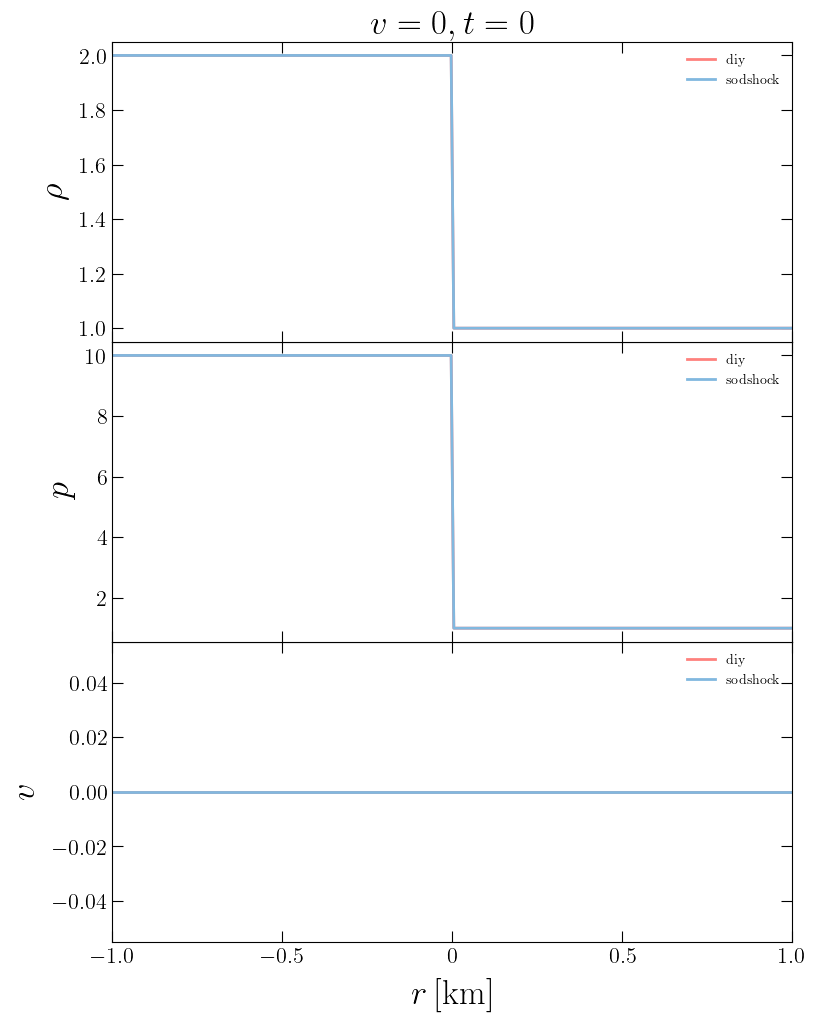

In [157]:
plot_fluid(r'$v = 0,t=0$')
plt.savefig('Figure/Fig1.pdf',bbox_inches='tight')

#### $t = 0.2$

In [158]:
# 通过自行构建的求解器求解
a = hydro_base( 256, -1, 1 );
a.init_cond( [ 2., 10. , 0 ], [ 1., 1. , 0 ], 0 );
while a.t < 2e-1:
    a.integrate(  );
rho, ene, mom = a.u.T;
vel = mom / rho;
pre = ( ene - vel**2 * rho / 2 ) * ( a.gam - 1 )
x   = a.xc;

# 通过sodshock库求解结果做对比
_, _, values = sodshock.solve\
( left_state  = (  10., 2., 0 ), \
  # pressure, density and velocity
  right_state = (  1.,  1., 0 ), \
  geometry    = ( -1.,  1.,   0 ), \
  t = a.t, gamma = a.gam, npts = a.n);

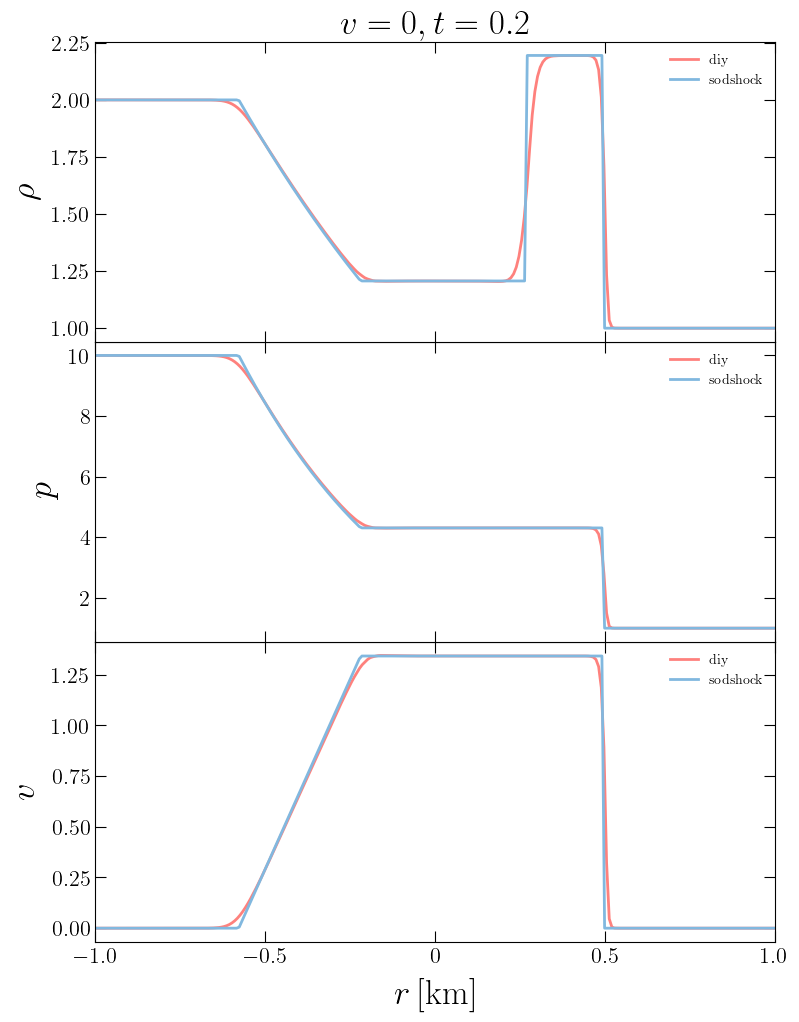

In [159]:
plot_fluid(r'$v = 0,t=0.2$')
plt.savefig('Figure/Fig2.pdf',bbox_inches='tight')

#### $t=1$

In [160]:
# 通过自行构建的求解器求解
a = hydro_base( 256, -1, 1 );
a.init_cond( [ 2., 10. , 0 ], [ 1., 1. , 0 ], 0 );
while a.t < 1:
    a.integrate(  );
rho, ene, mom = a.u.T;
vel = mom / rho;
pre = ( ene - vel**2 * rho / 2 ) * ( a.gam - 1 )
x   = a.xc;

# 通过sodshock库求解结果做对比
_, _, values = sodshock.solve\
( left_state  = (  10., 2., 0 ), \
  # pressure, density and velocity
  right_state = (  1.,  1., 0 ), \
  geometry    = ( -1.,  1.,   0 ), \
  t = a.t, gamma = a.gam, npts = a.n);

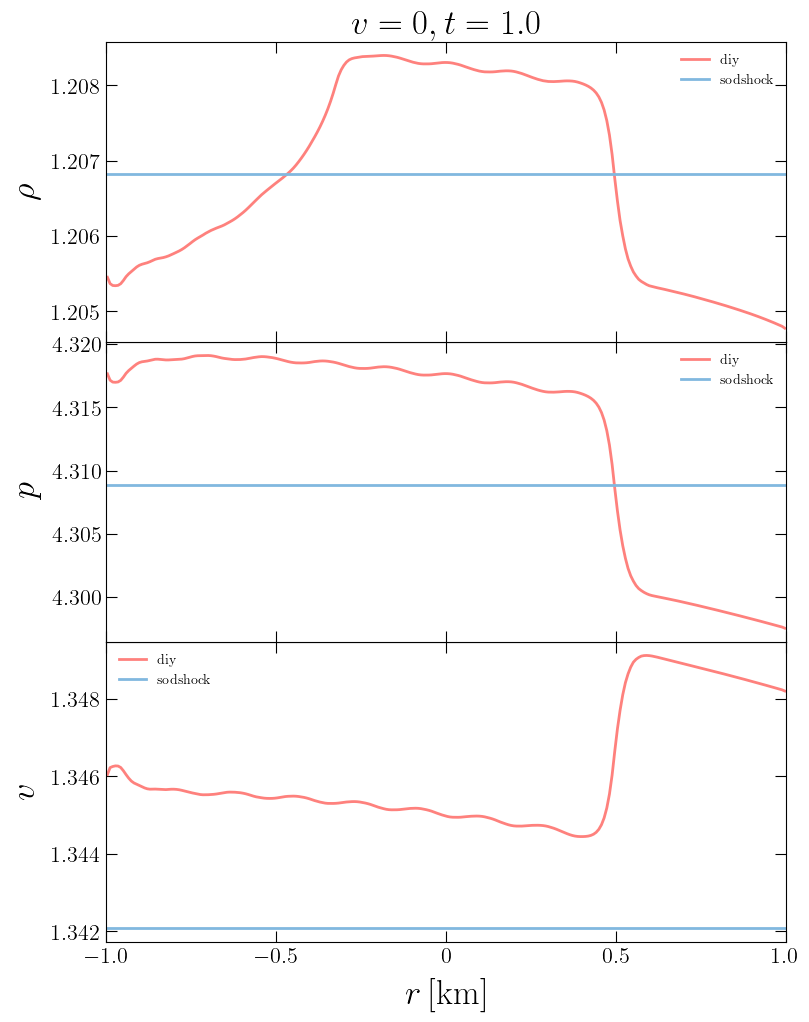

In [161]:
plot_fluid(r'$v = 0,t=1.0$')
plt.savefig('Figure/Fig3.pdf',bbox_inches='tight')

#### 流体有一个整体速度

In [162]:
a = hydro_base( 256, -1, 1 );
a.init_cond( [ 2., 10. , 0.2 ], [ 1., 1. , 0.2 ], 0 );
rho, ene, mom = a.u.T;
vel = mom / rho;
pre = ( ene - vel**2 * rho / 2 ) * ( a.gam - 1 )
x   = a.xc;

# 通过sodshock库求解结果做对比
_, _, values = sodshock.solve\
( left_state  = (  10., 2., 0.2 ), \
  # pressure, density and velocity
  right_state = (  1.,  1., 0.2 ), \
  geometry    = ( -1.,  1.,   0 ), \
  t = 0, gamma = a.gam, npts = a.n);

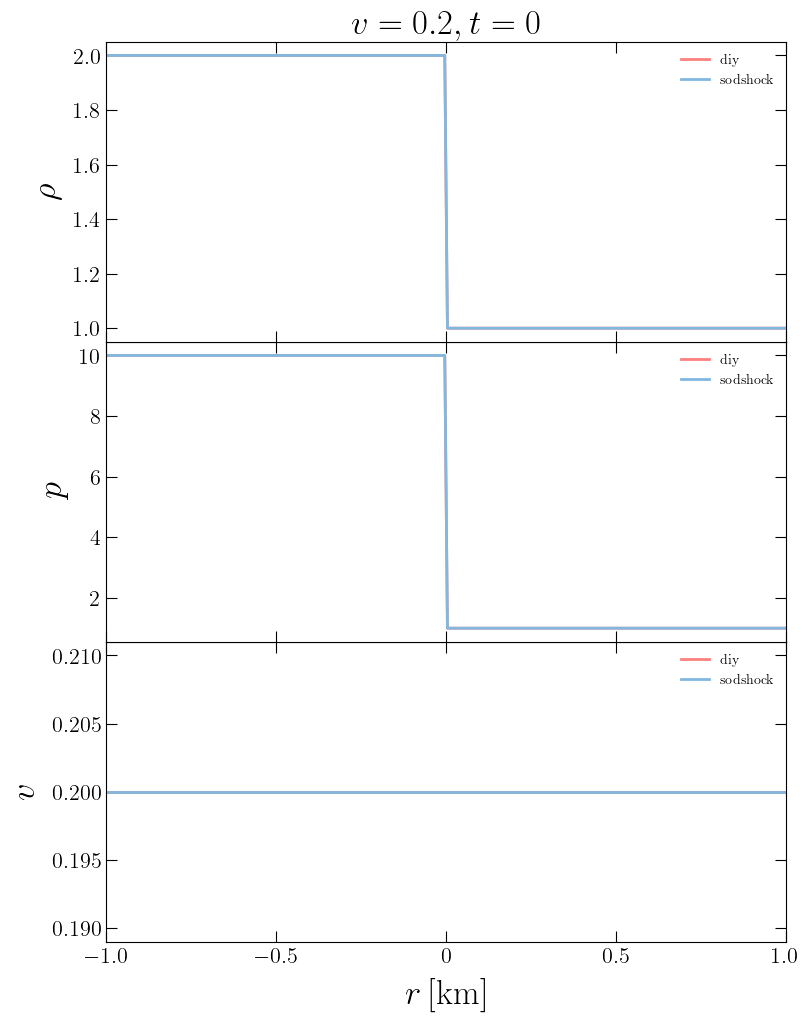

In [163]:
plot_fluid(r'$v = 0.2,t=0$')
plt.savefig('Figure/Fig4.pdf',bbox_inches='tight')

#### $t=0.2$

In [164]:
# 通过自行构建的求解器求解
a = hydro_base( 256, -1, 1 );
a.init_cond( [ 2., 10. , 0.2 ], [ 1., 1. , 0.2 ], 0 );
while a.t < 2e-1:
    a.integrate(  );
rho, ene, mom = a.u.T;
vel = mom / rho;
pre = ( ene - vel**2 * rho / 2 ) * ( a.gam - 1 )
x   = a.xc;

# 通过sodshock库求解结果做对比
_, _, values = sodshock.solve\
( left_state  = (  10., 2., 0.2 ), \
  # pressure, density and velocity
  right_state = (  1.,  1., 0.2 ), \
  geometry    = ( -1.,  1.,   0 ), \
  t = a.t, gamma = a.gam, npts = a.n);

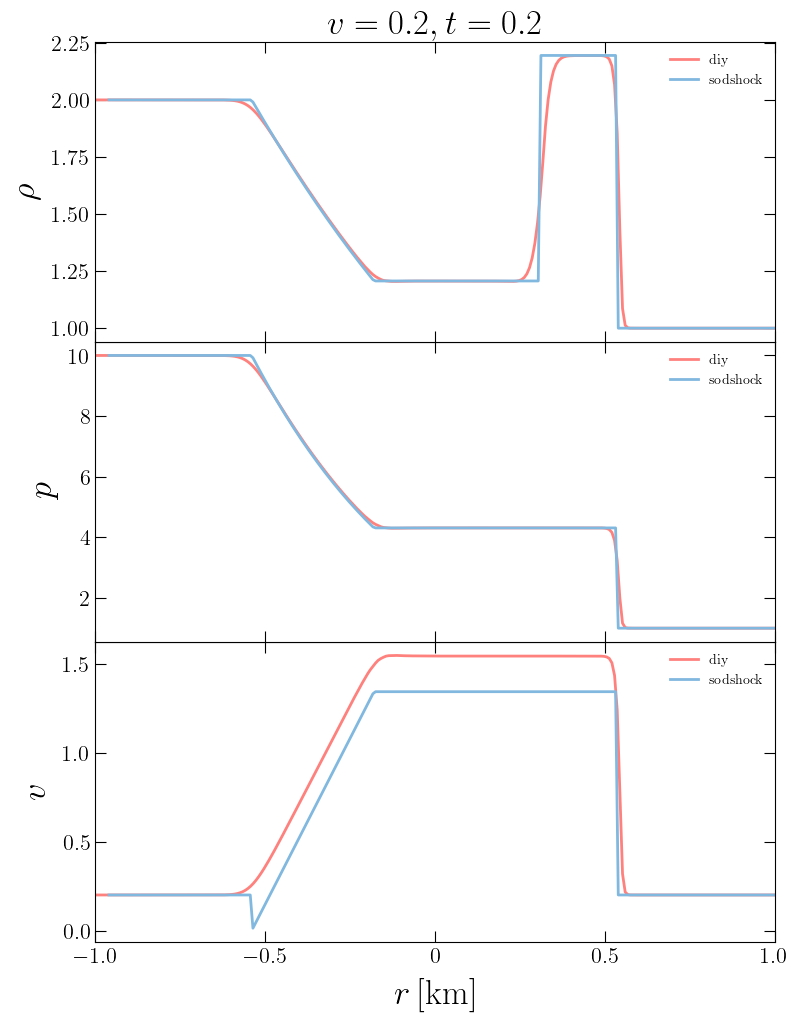

In [165]:
values[ 'x' ] = values[ 'x' ] + 0.2 * a.t
plot_fluid(r'$v = 0.2,t=0.2$')
plt.savefig('Figure/Fig5.pdf',bbox_inches='tight')

In [166]:
# 通过自行构建的求解器求解
a = hydro_base( 256, -1, 1 );
a.init_cond( [ 2., 10. , 0.2 ], [ 1., 1. , 0.2 ], 0 );
while a.t < 1:
    a.integrate(  );
rho, ene, mom = a.u.T;
vel = mom / rho;
pre = ( ene - vel**2 * rho / 2 ) * ( a.gam - 1 )
x   = a.xc;

# 通过sodshock库求解结果做对比
_, _, values = sodshock.solve\
( left_state  = (  10., 2., 0.2 ), \
  # pressure, density and velocity
  right_state = (  1.,  1., 0.2 ), \
  geometry    = ( -3.,  3.,   0 ), \
  t = a.t, gamma = a.gam, npts = a.n * 3);

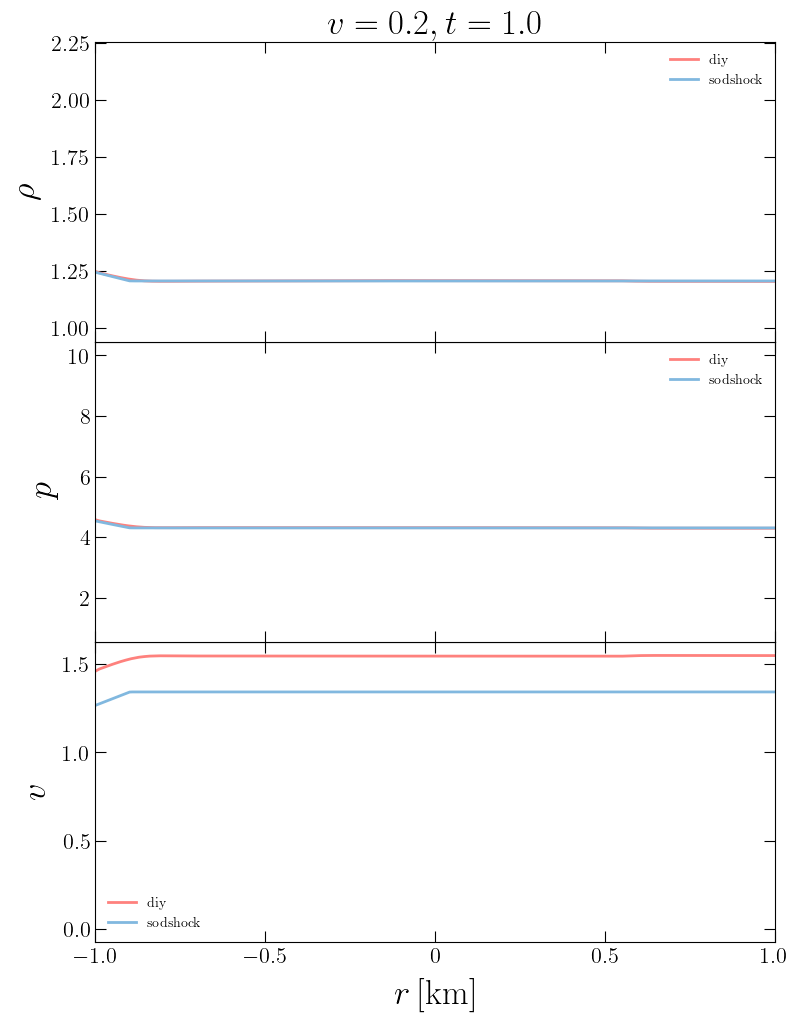

In [167]:
values[ 'x' ] = values[ 'x' ] + 0.2 * a.t
plot_fluid(r'$v = 0.2,t=1.0$')
plt.savefig('Figure/Fig6.pdf',bbox_inches='tight')

#### 速度为什么不一样？？？？


In [168]:
_, _, values1 = sodshock.solve\
( left_state  = (  10., 2., 0.2 ), \
  # pressure, density and velocity
  right_state = (  1.,  1., 0.2 ), \
  geometry    = ( -3.,  3.,   0 ), \
  t = a.t, gamma = a.gam, npts = a.n * 3);

_, _, values2 = sodshock.solve\
( left_state  = (  10., 2., 0.4 ), \
  # pressure, density and velocity
  right_state = (  1.,  1., 0.4 ), \
  geometry    = ( -3.,  3.,   0 ), \
  t = a.t, gamma = a.gam, npts = a.n * 3);

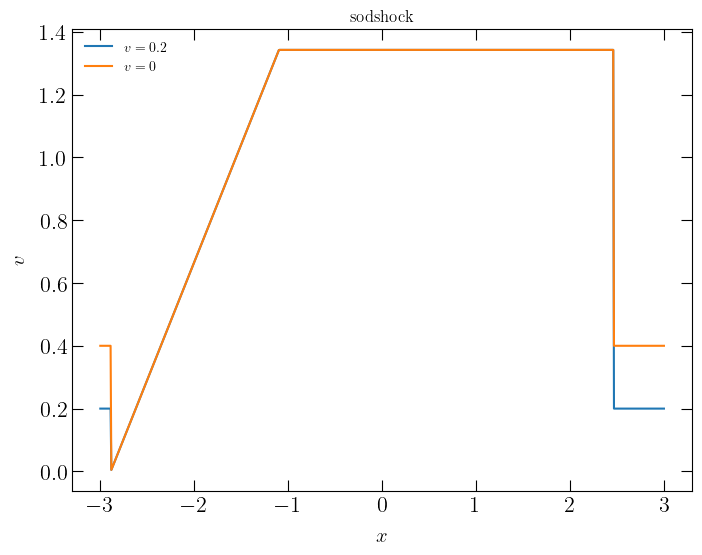

In [185]:
fig = plt.figure(figsize = (8,6))
plot(values1['x'],values1['u'])
plot(values2['x'],values2['u'])
plt.xlabel(r'$x$',size = 15)
plt.ylabel(r'$v$',size = 15)
plt.legend([r'$v=0.2$',r'$v=0$'],frameon=False)
plt.title('sodshock')
plt.savefig('Figure/Fig7.pdf',bbox_inches='tight')

In [182]:
a = hydro_base( 256, -1, 1 );
a.init_cond( [ 2., 10. , 0.2 ], [ 1., 1. , 0.2 ], 0 );
while a.t < 1:
    a.integrate(  );
arho, aene, amom = a.u.T;
avel = amom / arho;
apre = ( aene - avel**2 * arho / 2 ) * ( a.gam - 1 )
ax   = a.xc;

b = hydro_base( 256, -1, 1 );
b.init_cond( [ 2., 10. , 0 ], [ 1., 1. , 0 ], 0 );
while b.t < 1:
    b.integrate(  );
brho, bene, bmom = b.u.T;
bvel = bmom / brho;
bpre = ( bene - bvel**2 * brho / 2 ) * ( b.gam - 1 )
bx   = b.xc;

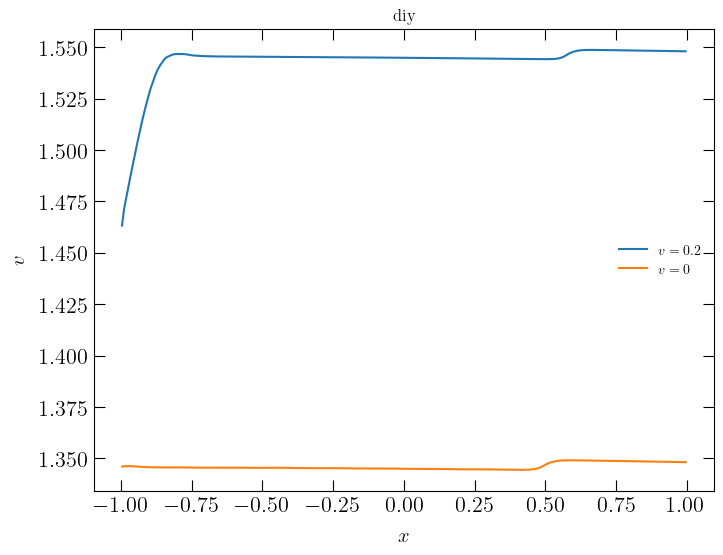

In [186]:
fig = plt.figure(figsize = (8,6))
plot(ax, avel)
plot(bx, bvel)
plt.xlabel(r'$x$',size = 15)
plt.ylabel(r'$v$',size = 15)
plt.legend([r'$v=0.2$',r'$v=0$'],frameon=False)
plt.title('diy')
plt.savefig('Figure/Fig8.pdf',bbox_inches='tight')
